In [1]:
filename = "results/comparison_results_custom_200.csv"

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple, Optional, Any

try:
    from pandas.io.formats.style import Styler
except Exception:
    Styler = Any


def _geo_mean(x: pd.Series) -> float:
    x = pd.to_numeric(x, errors="coerce")
    x = x[(x > 0) & np.isfinite(x)]
    if len(x) == 0:
        return np.nan
    return float(np.exp(np.log(x).mean()))


def make_results_table_with_geo(
    csv_file: str,
    write_tex: Optional[str] = None,
) -> Tuple[pd.DataFrame, Styler, Optional[str]]:
    df = pd.read_csv(csv_file)
    circuit = df["qasm_file"].astype(str).apply(lambda p: Path(p).name.replace(".qasm", ""))

    out = pd.DataFrame({
        ("", "Circuit"): circuit,
        ("SABRE (200 layout & swap trials)", "SWAP"): df["sabre_swaps"],
        ("SABRE (200 layout & swap trials)", "Depth"): df["sabre_depth"],
        ("SABRE (200 layout & swap trials)", "2Q Depth"): df["sabre_2q_depth"],
        ("SABRE (200 layout & swap trials)", "Runtime (s)"): df["sabre_time_s"],
        ("ML-SABRE (10 cycles)", "SWAP"): df["multilevel_swaps"],
        ("ML-SABRE (10 cycles)", "Depth"): df["multilevel_depth"],
        ("ML-SABRE (10 cycles)", "2Q Depth"): df["multilevel_2q_depth"],
        ("ML-SABRE (10 cycles)", "Runtime (s)"): df["multilevel_time_s"],
    }).sort_values(("", "Circuit")).reset_index(drop=True)

    # --- Geo. Ratio row values (keep as floats) ---
    def ratio_gmean(s_col, m_col):
        r = df[s_col] / df[m_col].replace(0, np.nan)
        return _geo_mean(r)

    geo_row = {
        ("", "Circuit"): "Geo. Ratio",
        ("SABRE (200 layout & swap trials)", "SWAP"): ratio_gmean("sabre_swaps", "multilevel_swaps"),
        ("SABRE (200 layout & swap trials)", "Depth"): ratio_gmean("sabre_depth", "multilevel_depth"),
        ("SABRE (200 layout & swap trials)", "2Q Depth"): ratio_gmean("sabre_2q_depth", "multilevel_2q_depth"),
        ("SABRE (200 layout & swap trials)", "Runtime (s)"): ratio_gmean("sabre_time_s", "multilevel_time_s"),
        ("ML-SABRE (10 cycles)", "SWAP"): 1.0,
        ("ML-SABRE (10 cycles)", "Depth"): 1.0,
        ("ML-SABRE (10 cycles)", "2Q Depth"): 1.0,
        ("ML-SABRE (10 cycles)", "Runtime (s)"): 1.0,
    }
    out = pd.concat([out, pd.DataFrame([geo_row])], ignore_index=True)

    # --- Formatters for normal rows ---
    def int_fmt(x):
        try:
            return f"{int(round(float(x)))}"
        except Exception:
            return ""

    def two_dec_fmt(x):
        try:
            return f"{float(x):.2f}"
        except Exception:
            return ""

    fmt = {}
    for col in out.columns:
        if col[1] == "Runtime (s)":
            fmt[col] = two_dec_fmt       # runtimes -> 2 decimals
        elif col[1] != "Circuit":
            fmt[col] = int_fmt           # other metrics -> integers

    styler = out.style.format(fmt)

    # --- Override formatting ONLY for the Geo. Ratio row (2 decimals everywhere except Circuit) ---
    geo_idx = out.index[out[("", "Circuit")] == "Geo. Ratio"]
    if len(geo_idx):
        geo_idx = [int(geo_idx[0])]
        cols_to_override = [c for c in out.columns if c[1] not in ("Circuit", "Runtime (s)")]
        idx = pd.IndexSlice
        styler = styler.format(two_dec_fmt, subset=idx[geo_idx, cols_to_override])
        # runtime columns already 2 decimals; leave as is

    # Hide index for cleaner notebook view
    try:
        styler = styler.hide(axis="index")
    except Exception:
        styler = styler.hide_index()

    # Optional LaTeX export (keeps the numeric values as-is; rendering/rounding is done by Styler in notebook)
    latex_str = None
    if write_tex:
        flat = out.copy()
        flat.columns = [(a + " - " + b).strip(" - ") if a else b
                        for a, b in flat.columns.to_list()]
        latex_str = flat.to_latex(index=False, escape=True)
        Path(write_tex).write_text(latex_str)
        print(f"Wrote LaTeX table to: {write_tex}")

    return out, styler, latex_str


In [3]:
df_table, styled, _ = make_results_table_with_geo(
    filename,
    write_tex="results_table.tex"  # optional
)
styled  # displays a clean, grouped table inline


Wrote LaTeX table to: results_table.tex


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Get your results and flatten to friendly column names ---
df_ours_raw, _, _ = make_results_table_with_geo(filename)

# Drop the Geo. Ratio row for per-circuit comparison
df_ours_raw = df_ours_raw[df_ours_raw[("", "Circuit")] != "Geo. Ratio"].copy()

# Flatten the MultiIndex columns to match the paper-like names
flat_cols = [
    "Circuit",
    "SABRE SWAP", "SABRE Depth", "SABRE 2Q Depth", "SABRE Runtime",
    "ML-SABRE SWAP", "ML-SABRE Depth", "ML-SABRE 2Q Depth", "ML-SABRE Runtime",
]
df_ours = df_ours_raw.copy()
df_ours.columns = flat_cols

# --- 2) Enter ORIGINAL values (from the paper screenshot) ---
# If the original table does NOT include 2Q Depth, just omit those columns here.
df_original = pd.DataFrame({
    "Circuit": ["adder_n118","bv_n70","cat_n65","ghz_n78","ising_n98",
                "dnn_n51","knn_n67","multiplier_n45","qft_n63",
                "qugan_n71","swap_test_n83","wstate_n118"],
    "SABRE SWAP":   [438, 28, 21, 23, 23, 127, 113, 1465, 1803, 212, 151, 85],
    "SABRE Depth":  [1187, 131, 100, 117, 22, 508, 477, 3439, 1040, 634, 595, 511],
    "SABRE Runtime":[7.57, 0.55, 0.63, 0.67, 1.56, 2.52, 1.84, 20.43, 22.61, 3.94, 2.36, 3.28],
    "ML-SABRE SWAP":[264, 27, 0, 0, 0, 113, 87, 1435, 1780, 165, 118, 13],
    "ML-SABRE Depth":[913, 128, 68, 81, 11, 418, 456, 3252, 949, 596, 563, 486],
    "ML-SABRE Runtime":[3.75, 1.05, 0.03, 0.03, 0.04, 2.26, 1.55, 18.34, 22.88, 2.73, 2.44, 1.79],
    # If you also have originals for 2Q depth, add:
    # "SABRE 2Q Depth":[...],
    # "ML-SABRE 2Q Depth":[...],
})

# --- 3) Merge with suffixes so columns *exist* like *_orig / *_ours ---
df_compare = df_original.merge(df_ours, on="Circuit", suffixes=("_orig", "_ours"))
df_compare



,Circuit,SABRE SWAP_orig,SABRE Depth_orig,SABRE Runtime_orig,ML-SABRE SWAP_orig,ML-SABRE Depth_orig,ML-SABRE Runtime_orig,SABRE SWAP_ours,SABRE Depth_ours,SABRE 2Q Depth,SABRE Runtime_ours,ML-SABRE SWAP_ours,ML-SABRE Depth_ours,ML-SABRE 2Q Depth,ML-SABRE Runtime_ours
0,adder_n118,438,1187,7.57,264,913,3.75,207.0,240.0,175.0,3.0590,117.0,190.0,132.0,1.3289
1,bv_n70,28,131,0.55,27,128,1.05,34.0,64.0,60.0,0.6122,26.0,64.0,60.0,0.6422
2,cat_n65,21,100,0.63,0,68,0.03,21.0,86.0,84.0,0.6635,0.0,66.0,64.0,0.0590
3,ghz_n78,23,117,0.67,0,81,0.03,23.0,101.0,99.0,0.8146,0.0,79.0,77.0,0.0583
4,ising_n98,23,22,1.56,0,11,0.04,24.0,31.0,12.0,2.1627,0.0,16.0,4.0,0.0860
5,dnn_n51,127,508,2.52,113,418,2.26,6.0,71.0,65.0,0.4455,0.0,58.0,52.0,0.0616
6,multiplier_n45,1465,3439,20.43,1435,3252,18.34,0.0,462.0,234.0,0.4973,0.0,462.0,234.0,0.0137
7,qft_n63,1803,1040,22.61,1780,949,22.88,1975.0,1267.0,749.0,31.9748,2313.0,1440.0,888.0,14.3690
8,qugan_n71,212,634,3.94,165,596,2.73,21.0,91.0,80.0,0.8501,21.0,94.0,81.0,0.8201
9,swap_test_n83,151,595,2.36,118,563,2.44,0.0,44.0,0.0,0.0149,0.0,44.0,0.0,0.0076


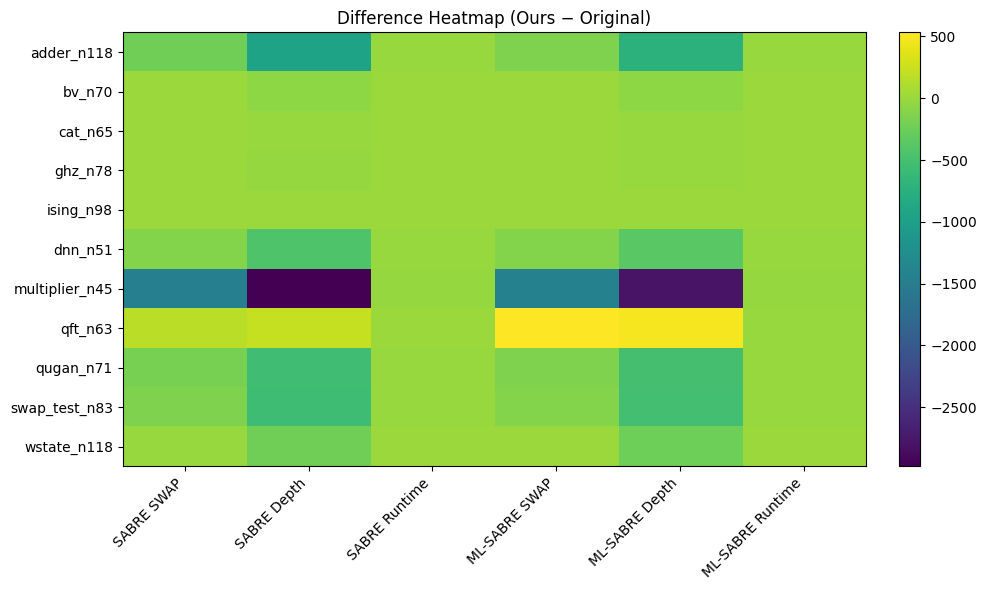

Largest absolute differences:
 SABRE Depth         2977.0000
ML-SABRE Depth      2790.0000
SABRE SWAP          1465.0000
ML-SABRE SWAP       1435.0000
SABRE Runtime         19.9327
ML-SABRE Runtime      18.3263
dtype: float64


In [5]:
# Choose metrics to compare based on columns both tables share
all_metric_bases = [
    "SABRE SWAP", "SABRE Depth", "SABRE 2Q Depth", "SABRE Runtime",
    "ML-SABRE SWAP", "ML-SABRE Depth", "ML-SABRE 2Q Depth", "ML-SABRE Runtime",
]
metric_bases = [m for m in all_metric_bases if m+"_orig" in df_compare.columns and m+"_ours" in df_compare.columns]

# --- 4) Build Differences (ours - original) and plot a heatmap ---
diff = df_compare[[m+"_ours" for m in metric_bases]].to_numpy() - \
       df_compare[[m+"_orig" for m in metric_bases]].to_numpy()

diff_df = pd.DataFrame(diff, columns=metric_bases, index=df_compare["Circuit"])

plt.figure(figsize=(10, 6))
im = plt.imshow(diff_df.values, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(metric_bases)), labels=metric_bases, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(diff_df.index)), labels=diff_df.index)
plt.title("Difference Heatmap (Ours − Original)")
plt.tight_layout()
plt.show()

# Optional: print a quick summary table of absolute diffs
absmax = diff_df.abs().max().sort_values(ascending=False)
print("Largest absolute differences:\n", absmax.head(10))

In [6]:
# Pick which metrics to plot
metrics_to_plot = ["SABRE SWAP", "SABRE Depth", "SABRE Runtime",
                   "ML-SABRE SWAP", "ML-SABRE Depth", "ML-SABRE Runtime"]

# Melt into long form for plotting
df_long = pd.melt(
    df_compare,
    id_vars="Circuit",
    value_vars=[m+"_orig" for m in metrics_to_plot] + [m+"_ours" for m in metrics_to_plot],
    var_name="Metric",
    value_name="Value"
)

# Split out method and version (orig vs ours)
df_long["Version"] = df_long["Metric"].apply(lambda x: "Original" if x.endswith("_orig") else "Ours")
df_long["Metric"] = df_long["Metric"].str.replace("_orig","").str.replace("_ours","")

# Plot each metric separately
for metric in metrics_to_plot:
    plt.figure(figsize=(12,5))
    sns.barplot(
        data=df_long[df_long["Metric"] == metric],
        x="Circuit", y="Value", hue="Version"
    )
    plt.title(f"{metric}: Original vs Ours")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


NameError: name 'sns' is not defined

<Figure size 1200x500 with 0 Axes>